In [1]:
import sys
sys.path.append('../src')
sys.path.append('../src/data/')
sys.path.append('../src/models/')
sys.path.append('../src/features/')
sys.path.append('../src/visualization/')
# will reload any library
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# sportify specific
#from data.metrics import r_precision, cosine_sim_closest, cosine_sim_top, NDCG
from visualization.plot_utils import write_latex_table, summary_pooling_table,\
pooling_plots, pandas_settings, plot_settings,  save_result
# general
import pandas as pd
import numpy as np
from tqdm import tqdm
from features import AudioFeatures, TrackInfo, Popularity, GenreLDA, AlbumFeature, TrackFeature, ArtistFeature
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
# for bayesopt
import GPy
import GPyOpt
plot_settings()
pandas_settings()

def ranked_plots(pool,true,ranked,dist,f_name,r_type):
    sns.distplot([d for d,t in zip(dist,pool) if t in true],label='In playlist')
    sns.distplot([d for d,t in zip(dist,pool) if t not in true],label='Not in playlist')
    plt.ylabel('Normalized frequency')
    plt.xlabel('Distance')
    plt.title('{} with {}'.format(f_name,r_type))
    plt.legend()
    plt.show()
    true_rank = [i for i,t in enumerate(true)]
    estimated_rank = [i for i,t in enumerate(ranked) if t in true]
    
    plt.scatter(true_rank,estimated_rank)
    plt.plot([0, len(true)],[0, len(true)],'--',c='k',label='ideal')
    plt.xlabel('Real ranking')
    plt.ylabel('Estimated ranking')
    plt.title('{} with {}'.format(f_name,r_type))
    plt.show()

# Load track data and features

In [3]:
tracks = TrackInfo(subset='5k-')
feats = [AudioFeatures(),Popularity(),GenreLDA(),AlbumFeature(),TrackFeature(),ArtistFeature()]

LOADING AUDIO FEATURE...
FINISHED LOADING AUDIO FEATURE...
../data/interim/track_uri2popularity.pkl.bz2 IS LOADING...
LOADED POPULARITY
../data/w2v/album_128_1cut IS LOADING
LOADED W2V
../data/w2v/track_128_1cut IS LOADING
LOADED W2V
../data/w2v/artist_128_1cut IS LOADING
LOADED W2V


In [6]:
from data.metrics import r_precision, NDCG

def ranking_stats(pid,k,strat,n_pick,true_t,pool_t,true_a,pool_a):
    rp_t = r_precision(true_t,pool_t)
    ndgc_t = NDCG(true_t,pool_t)
    rp_a = r_precision(true_a,pool_a)
    ndgc_a = NDCG(true_a,pool_a)
    return OrderedDict([('pid',pid),('k',k),('strat',strat),('n',n_pick),
                        ('rprecision_tracks',rp_t),('rprecision_artist',rp_a),
                        ('NDCG_tracks',ndgc_t),('NDCG_artist',ndgc_a)])


# Test one playlist vs 1 feature

In [7]:
# select a feature
f = feats[-1]
k=25
n_picks=5000
pid=194
strat='medoid'
# rankign based on distances
turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
dist = f.distance_between_sets(turi_seed,turi_pool,strat)
sorted_indx=np.argsort(dist)
turi_ranked = [turi_pool[i] for i in sorted_indx]
auri_ranked = [auri_pool[i] for i in sorted_indx]
pd.DataFrame([ranking_stats(pid,k,strat,n_picks,turi_true,turi_pool,auri_true,auri_pool)])

,pid,k,strat,n,rprecision_tracks,rprecision_artist,NDCG_tracks,NDCG_artist
0,194,25,medoid,5000,0.01,0.03,0.36,0.91


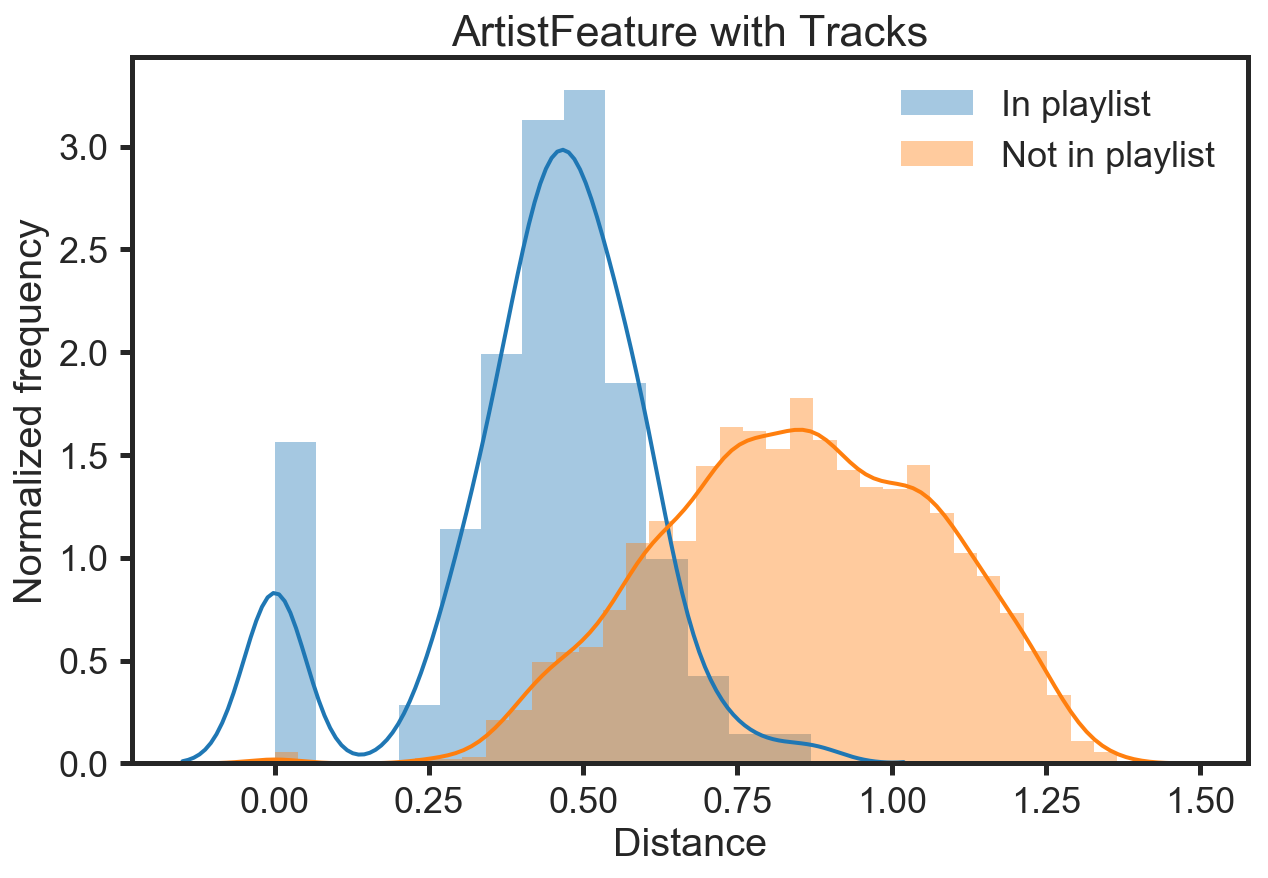

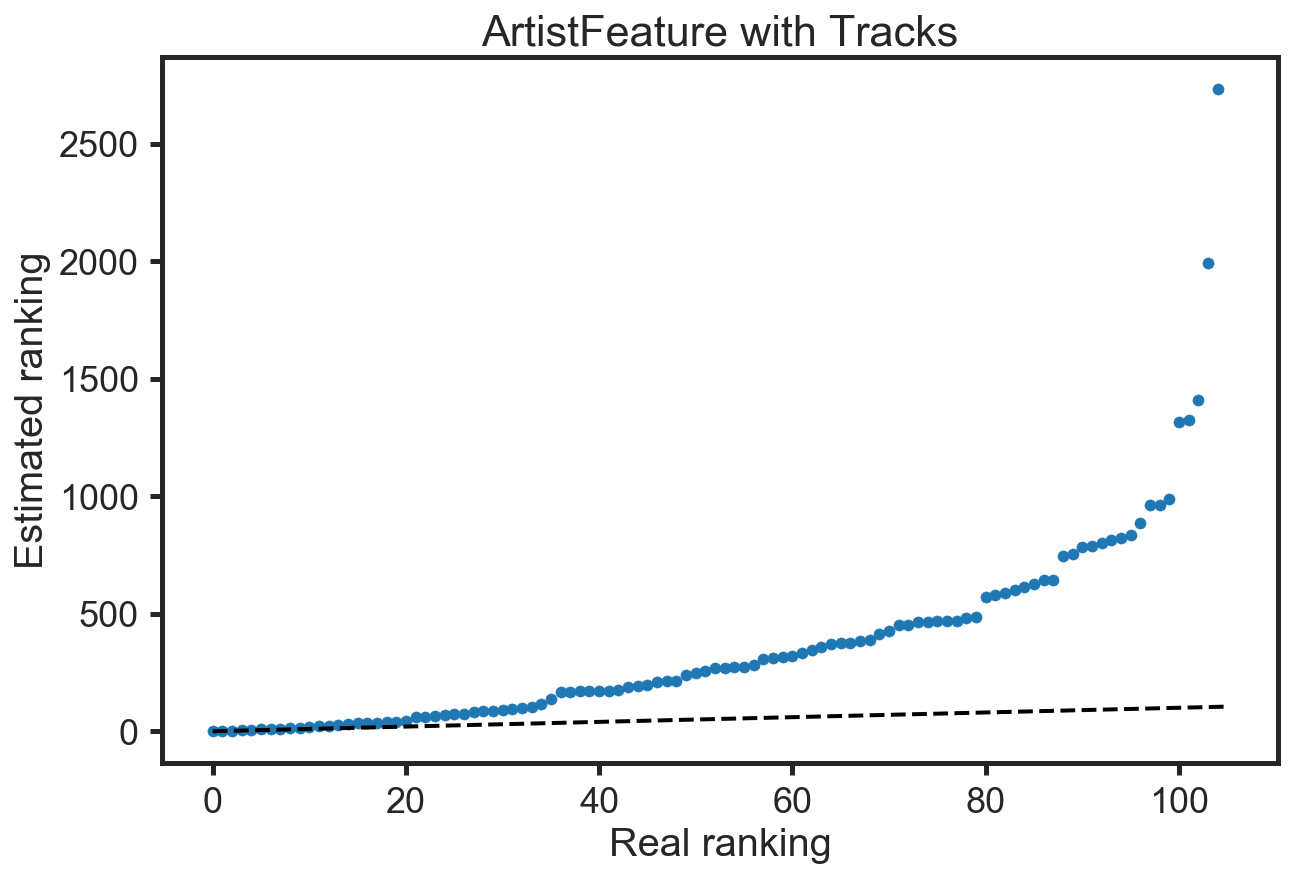

In [8]:
f_name= f.__class__.__name__
ranked_plots(turi_pool,turi_true,turi_ranked,dist,f_name,'Tracks')

# One playlist vs several features

In [9]:
# select a feature
k=25
n_picks=5000
pid=194
strat='all'
weights= [1 for f in feats]
# rankign based on distances
turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
# get scaled distance
dist = np.zeros(len(turi_pool))
for f,w in zip(feats,weights):
    dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat)
# rank based on 
sorted_indx=np.argsort(dist)
turi_ranked = [turi_pool[i] for i in sorted_indx]
auri_ranked = [auri_pool[i] for i in sorted_indx]
stats = ranking_stats(pid,k,strat,n_picks,turi_true,turi_pool,auri_true,auri_pool)
stats['rprecision_tracks']

0.01904761904761905

# Bayesopt the weights and startegies

## Setup optimization parameter space


In [25]:
f_names

['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']

In [24]:
domains=[]
f_names= []
strats = ['mean','all','centroid','medoid']
strat_dom = tuple(list([i for i,x in enumerate(strats)]))
for f in feats:
    f_name = f.__class__.__name__
    f_names.append(f_name.replace('Feature','').replace('LDA','').replace('Audios','AudioFeatures'))
    domains.append({'name':'{}_weight'.format(f_name), 'type': 'continuous', 'domain': (0.,50.0)})
    domains.append({'name':'{}_strat'.format(f_name), 'type': 'categorical', 'domain': strat_dom,'dimensionality': 1})
domains

[{'domain': (0.0, 50.0), 'name': 'AudioFeatures_weight', 'type': 'continuous'},
 {'dimensionality': 1,
  'domain': (0, 1, 2, 3),
  'name': 'AudioFeatures_strat',
  'type': 'categorical'},
 {'domain': (0.0, 50.0), 'name': 'Popularity_weight', 'type': 'continuous'},
 {'dimensionality': 1,
  'domain': (0, 1, 2, 3),
  'name': 'Popularity_strat',
  'type': 'categorical'},
 {'domain': (0.0, 50.0), 'name': 'GenreLDA_weight', 'type': 'continuous'},
 {'dimensionality': 1,
  'domain': (0, 1, 2, 3),
  'name': 'GenreLDA_strat',
  'type': 'categorical'},
 {'domain': (0.0, 50.0), 'name': 'AlbumFeature_weight', 'type': 'continuous'},
 {'dimensionality': 1,
  'domain': (0, 1, 2, 3),
  'name': 'AlbumFeature_strat',
  'type': 'categorical'},
 {'domain': (0.0, 50.0), 'name': 'TrackFeature_weight', 'type': 'continuous'},
 {'dimensionality': 1,
  'domain': (0, 1, 2, 3),
  'name': 'TrackFeature_strat',
  'type': 'categorical'},
 {'domain': (0.0, 50.0), 'name': 'ArtistFeature_weight', 'type': 'continuous'},


In [48]:
def eval_on_playlists(weights,f_strats,k=25,n_picks=10000,n_pids=50):
    stats=[]
    subset=500
    pids = [i for i in np.random.randint(0,5000,n_pids)]
    for pid in pids:
        turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
        if len(turi_true) > 0:
            # get scaled distance
            dist = np.zeros(len(turi_pool))
            for f,w,st in zip(feats,weights,f_strats):
                dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat=st)
            # rank based on distance
            sorted_indx=np.argsort(dist)
            turi_ranked = [turi_pool[i] for i in sorted_indx][:subset]
            auri_ranked = [auri_pool[i] for i in sorted_indx][:subset]
            # get starts
            stats.append(ranking_stats(pid,k,strat,n_picks,turi_true,turi_ranked,auri_true,auri_ranked))
        stats_df = pd.DataFrame(stats)
    return stats_df

In [80]:
verbose=True
iter_n=0

def separate_x(x):
    weights = [x[0][indx] for indx,i in enumerate(x[0]) if indx%2==0]
    x_strats = [strats[int(x[0][indx])] for indx,i in enumerate(x[0]) if indx%2==1]
    return weights,x_strats

def print_msg(n,val,f_names,weights,x_strats):
    print('{}: r-precision of {:.3f}'.format(n,val))
    print('\t {}'.format(str([f_n for f_n in f_names])))
    print('\t {}'.format(str(['{:2.3f}'.format(w) for w in  weights])))
    print('\t {}'.format(str(['{:s}'.format(s) for s in  x_strats])))

def rprecision_eval(x):
    global iter_n
    weights,x_strats = separate_x(x)
    stats_df = eval_on_playlists(weights,x_strats,k=50,n_picks=10000,n_pids=100)
    # we wish to minize
    objective  = 1.0-np.mean(stats_df['rprecision_tracks'].values)
    #
    if verbose:
        print_msg(iter_n,1-objective,f_names,weights,x_strats)
    iter_n+=1
    
    return objective


In [ ]:
bopt = GPyOpt.methods.BayesianOptimization(f=rprecision_eval,                     # Objective function       
                                             domain=domains,          # Box-constraints of the problem
                                             initial_design_numdata = 5,   # Number data initial design
                                             acquisition_type='EI',        # Expected Improvement
                                             exact_feval = True)           # True evaluations, no sample noise

0: r-precision of 0.223
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['9.808', '24.019', '41.520', '21.590', '11.516', '19.362']
	 ['centroid', 'all', 'medoid', 'all', 'all', 'centroid']
1: r-precision of 0.291
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['22.638', '49.391', '45.825', '18.417', '39.086', '18.260']
	 ['centroid', 'centroid', 'centroid', 'mean', 'mean', 'mean']
2: r-precision of 0.209
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['26.052', '33.162', '36.035', '49.561', '17.249', '49.034']
	 ['mean', 'all', 'medoid', 'all', 'medoid', 'centroid']
3: r-precision of 0.233
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['8.830', '25.919', '11.892', '17.626', '46.854', '19.994']
	 ['medoid', 'mean', 'all', 'medoid', 'mean', 'medoid']
4: r-precision of 0.210
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['25.526', '10.741', '31.548', '11.308'

In [ ]:
max_iter=250
bopt.run_optimization(max_iter,eps=0)

5: r-precision of 0.237
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['27.757', '46.358', '40.546', '23.722', '35.089', '13.479']
	 ['all', 'medoid', 'centroid', 'centroid', 'medoid', 'centroid']
6: r-precision of 0.215
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['21.084', '42.947', '35.026', '25.416', '37.300', '17.909']
	 ['medoid', 'medoid', 'medoid', 'centroid', 'mean', 'medoid']
7: r-precision of 0.152
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['49.283', '5.311', '47.703', '23.524', '11.332', '6.500']
	 ['mean', 'centroid', 'all', 'medoid', 'all', 'centroid']
8: r-precision of 0.223
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['27.412', '49.096', '40.962', '21.139', '33.917', '16.663']
	 ['all', 'all', 'centroid', 'medoid', 'all', 'mean']
9: r-precision of 0.234
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['30.242', '46.464', '42.852', 

43: r-precision of 0.195
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['32.563', '46.175', '39.179', '21.358', '37.321', '15.151']
	 ['centroid', 'mean', 'all', 'medoid', 'all', 'medoid']
44: r-precision of 0.247
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['8.888', '32.718', '38.677', '12.797', '3.513', '19.444']
	 ['all', 'centroid', 'centroid', 'mean', 'all', 'mean']
45: r-precision of 0.189
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['5.568', '26.747', '35.747', '18.200', '18.032', '14.883']
	 ['mean', 'medoid', 'mean', 'medoid', 'medoid', 'mean']
46: r-precision of 0.218
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['2.069', '29.434', '34.540', '24.840', '14.947', '12.049']
	 ['medoid', 'mean', 'medoid', 'mean', 'all', 'all']
47: r-precision of 0.242
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['4.896', '26.562', '21.023', '23.141', '42.26

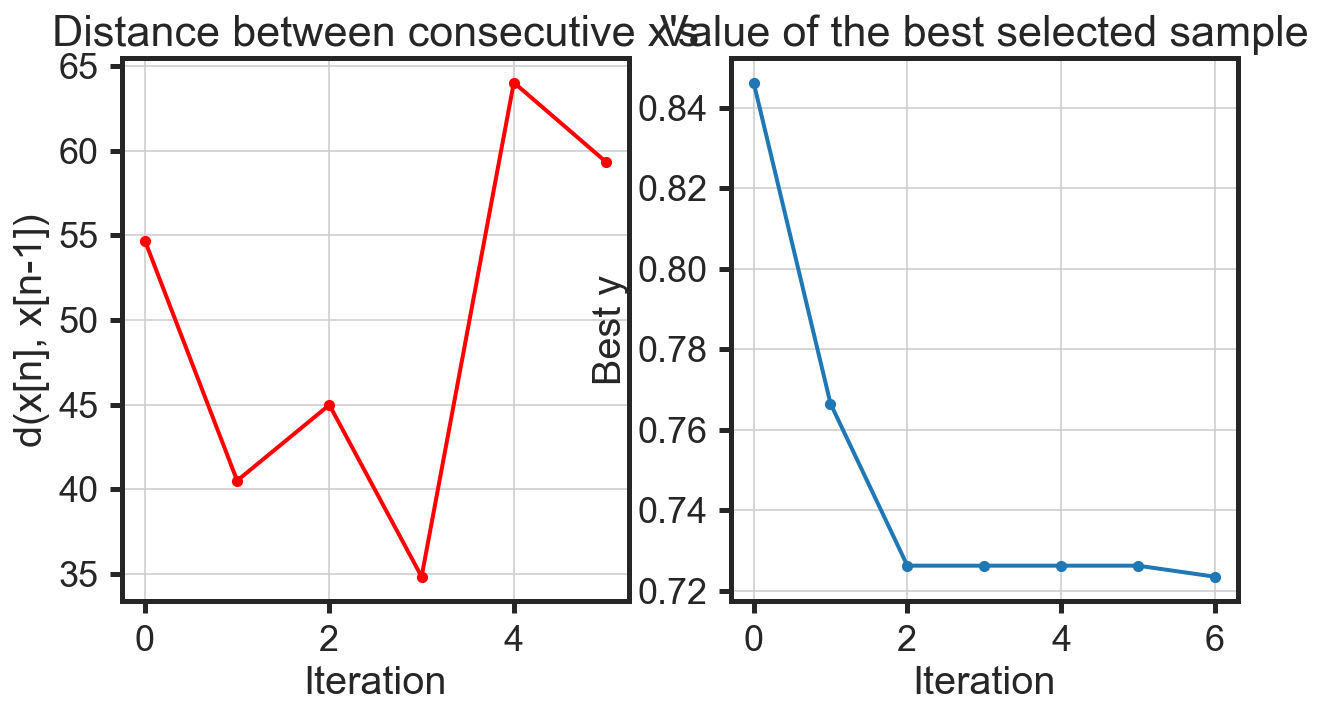

In [53]:
bopt.plot_convergence()

## best solution

In [64]:
x_opt =  bopt.x_opt
fx_opt = bopt.fx_opt[0]
weights,x_strats = separate_x([x_opt])
print_msg('best',fx_opt,f_names,weights,x_strats)

best: r-precision of 0.723
	 ['AudioFeatures', 'Popularity', 'Genre', 'Album', 'Track', 'Artist']
	 ['11.407', '47.464', '47.417', '49.745', '32.137', '44.510']
	 ['all', 'mean', 'medoid', 'all', 'centroid', 'mean']


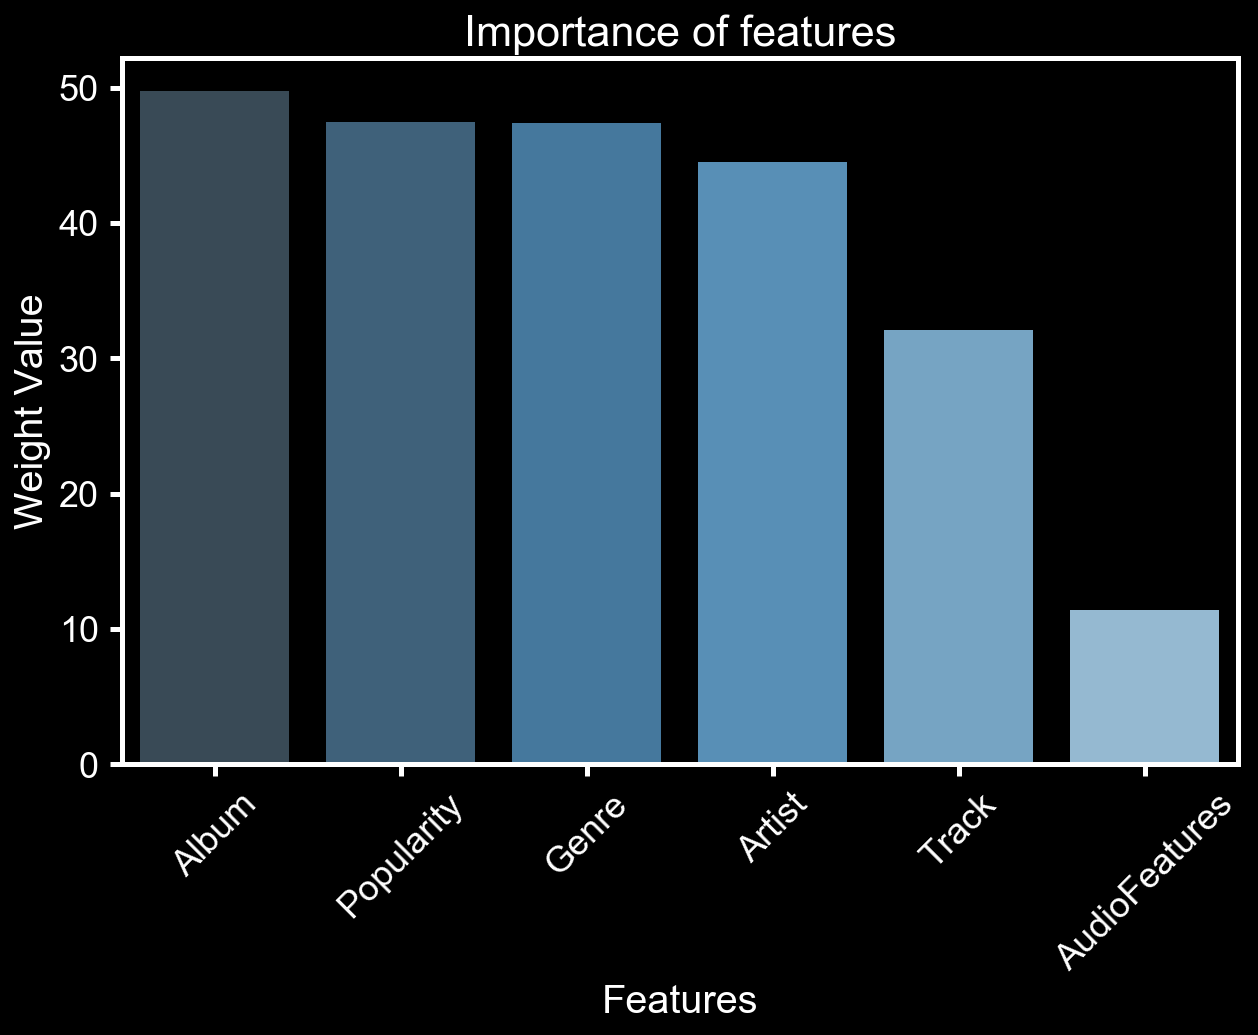

In [74]:
plt.style.use('dark_background')
bar_df = pd.DataFrame()
bar_df['Features'] = f_names
bar_df['Weight Value'] = weights
bar_df.sort_values(by='Weight Value',inplace=True,ascending=False)
sns.barplot('Features', y="Weight Value", data=bar_df,palette="Blues_d")
plt.xticks(rotation=45)
plt.title('Importance of features')
plt.savefig('../reports/weights_inv.svg')
plt.savefig('../reports/weights_inv.png',dpi=300)
plt.show()

In [76]:
stats_df = pd.DataFrame()
for k in [5,10,25,50,100]:
    stats_df = stats_df.append(eval_on_playlists(weights,x_strats,k=k,n_picks=10000,n_pids=5000))
result_df = stats_df.groupby('k').agg({'rprecision_tracks':['mean'], 'rprecision_artist':['mean'],'NDCG_tracks':['mean'], 'NDCG_artist':['mean']})
write_latex_table(df=result_df,name='ranking',adir='../reports')
result_df

,rprecision_tracks,rprecision_artist,NDCG_tracks,NDCG_artist
,mean,mean,mean,mean
k,,,,
5,0.55,0.33,0.10,0.17
10,0.48,0.27,0.12,0.20
25,0.54,0.32,0.09,0.15
50,0.55,0.30,0.13,0.22
100,0.64,0.33,0.11,0.20
